In [1]:
import json
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions.normal as normal
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from nltk.tokenize import word_tokenize
from nltk.tokenize import MWETokenizer

from gensim.models import Word2Vec

torch.manual_seed(1)
np.random.seed(1)
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/eliisabethein/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Functions

In [2]:
def load_data(filename, max_sentence_len):
    # the tokenizer splits <unk> so we use MWETokenizer to re-merge it
    data_original = []
    data_padded = []
    with open(filename) as f:
        for line in f:
            sentence, padded_sentence = tokenize_sentence(line, max_sentence_len)
            data_original.append(sentence)
            data_padded.append(padded_sentence)
    
    return data_original, data_padded

In [3]:
def tokenize_sentence(string, max_sentence_len):
    merger = MWETokenizer([('<', 'unk', '>')], separator = '') 
    sentence = word_tokenize(string.strip())       # tokenize sentence
    sentence = merger.tokenize(sentence)         # merge <unk>
    sentence = sentence[:max_sentence_len - 2]   # cut sentence at max_sentence_length
    sentence = ['<sos>'] + sentence + ['<eos>']  # add start and end-of-sentence tags

    # pad the rest of the sentence
    padded_sentence = sentence.copy()
    padded_sentence.extend(['<pad>']*(max_sentence_len - len(sentence))) 
    
    return sentence, padded_sentence

In [4]:
def get_batches_text(data, data_padded, batch_size, pad_index, word2vec_model):
    inputs = []
    targets = []
    lengths = []
    for i in range(len(data) // batch_size):
        # take batch_size sentences from the data each time
        batch_sentences = data[i*batch_size:(i+1)*batch_size]
        batch_sentence_lens = [len(x) for x in batch_sentences]
        
        # sentences in a batch have to be sorted in decreasing order of length (for pack_padded_sentence)
        sorted_pairs = sorted(zip(batch_sentence_lens,batch_sentences), reverse=True)
        batch_sentences = [sentence for length, sentence in sorted_pairs]
        batch_sentence_lens = [length-1 for length, sentence in sorted_pairs]
        
        # each input and target is a (batch_size x max_sentence_len-1 x 1) matrix
        # initially filled with the index for padditng tag <pad>
        input_batch = np.ones((batch_size, len(data_padded[0])-1, 1)) * pad_index
        target_batch = np.ones((batch_size, len(data_padded[0])-1, 1)) * pad_index
        
        # for each sentence in the batch, fill the corresponding row in current_batch
        # with the indexed of the words in the sentence (except for <pad>)
        for j, sentence in enumerate(batch_sentences):
            word_indexes = np.array([word2vec_model.wv.vocab[word].index for word in sentence])
            input_batch[j,0:len(sentence)-1,0] = word_indexes[:-1]
            target_batch[j,0:len(sentence)-1,0] = word_indexes[1:]
        
        # make the matrices into torch tensors and append
        inputs.append(input_batch)
        targets.append(target_batch)
        lengths.append(batch_sentence_lens)
    return inputs, targets, lengths

def get_batches_synthetic(data, batch_size):
    inputs = []
    targets = []

    for i in range(len(data) // batch_size):
        batch_sentences = data[i * batch_size:(i+1) * batch_size]

        input_batch = np.ones((batch_size, data.shape[1] - 1, 1)) 
        target_batch = np.ones((batch_size, data.shape[1] - 1, 1)) 
        for j, sentence in enumerate(batch_sentences):
                input_batch[j,0:len(sentence)-1,0] = sentence[:-1]
                target_batch[j,0:len(sentence)-1,0] = sentence[1:]
        inputs.append(input_batch)
        targets.append(target_batch)
    
    return inputs, targets

### Load Penn Treebank data

In [5]:
# max_sentence_length = 50
# train_data, train_data_padded = load_data("data/ptb.train.txt", max_sentence_length)
# val_data, val_data_padded = load_data("data/ptb.valid.txt", max_sentence_length)
# test_data, test_data_padded = load_data("data/ptb.test.txt", max_sentence_length)

### Load Synthetic data

In [54]:
test_syn_data = np.loadtxt('./synthetic-data/synthetic_test.txt', dtype=int)
train_syn_data = np.loadtxt('./synthetic-data/synthetic_train.txt', dtype=int)

In [55]:
batch_size = 16

# load tracked inputs (for plotting)
random_indices = np.random.choice(train_syn_data.shape[0], 500)
tracked_inputs = []
tracked_targets = []
for random_index in random_indices:
    tracked_inputs.append(train_syn_data[random_index, :-1])
    tracked_targets.append(train_syn_data[random_index, 1:])
tracked_inputs = np.expand_dims(np.array(tracked_inputs), axis=-1)
tracked_targets = np.expand_dims(np.array(tracked_targets), axis=-1)

# load data into batches
inputs, targets = get_batches_synthetic(train_syn_data, batch_size)

### Create Word2Vec word embeddings

In [6]:
embedding_size = 500
num_epochs_to_train = 10

word2vec_model = Word2Vec(train_data, min_count=1, size=embedding_size, window=5)
word2vec_model.train(train_data, epochs=num_epochs_to_train, total_examples=word2vec_model.corpus_count)

word2vec_model.wv.most_similar("stocks")
# word2vec_model.wv['credit']

vocabulary_size = len(word2vec_model.wv.vocab)
print("size of the vocabulary:", vocabulary_size)

### Define RNNLM

In [28]:
class RNNLM(nn.Module):
    def __init__(self, vocabulary_size, embedding_size, hidden_size, num_layers, embedding_weights):
        super(RNNLM, self).__init__()
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocabulary_size)
        self.embedding_size = embedding_size
        
    def forward(self, x, hidden, x_lens, train=True):
        batch_size, max_len, _ = x.shape
        embedding_dim = self.embedding_size

        x = self.embed(torch.tensor(x, dtype=torch.long)).view(batch_size, max_len, embedding_dim)
        if train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=True)

        out, hidden = self.lstm(x.float(), hidden) 
        
        if train:
            out, output_lens = pad_packed_sequence(out, batch_first=True, total_length=max_sentence_length-1)

        out = out.reshape(out.size(0)*out.size(1), out.size(2))
        out = self.linear(out)
        
        return out, hidden

### Train and predict with RNNLM

In [5]:
input_size = 100
output_size = 100
hidden_size = 50

batch_size = 20
use_first_k = 500
padding_index = vocabulary_size
train_batches, train_targets, train_sentence_lens = get_batches(train_data[:use_first_k], train_data_padded[:use_first_k], 
                                                                batch_size, padding_index, word2vec_model)

# make the word embeddings into a pythorch tensor
embedding_weights = word2vec_model.wv.vectors
embedding_weights = np.vstack((embedding_weights, np.zeros((1,embedding_size))))  # add zero vector for <pad>
embedding_weights = torch.tensor(embedding_weights)

learning_rate = 0.001
num_layers = 1
epochs = 10

model = RNNLM(vocabulary_size, embedding_size, hidden_size, num_layers, embedding_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    hidden = (torch.zeros(num_layers, batch_size, hidden_size), torch.zeros(num_layers, batch_size, hidden_size))
    for i in range(len(train_batches)):
        x = train_batches[i]
        x_lens = train_sentence_lens[i]
        y = torch.tensor(train_targets[i].reshape(-1), dtype=torch.long)   
        h, c = hidden
        h = h.detach()
        c = c.detach()
        hidden = (h, c)
    
        outputs, hidden = model(x, hidden, x_lens)
        
        mask = (y < padding_index)
        loss = nn.CrossEntropyLoss()(outputs[mask], y[mask])

        model.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    if epoch % 1 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}'
               .format(epoch + 1, epochs, loss.item(), np.exp(loss.item())))

In [97]:
# Predict
test_sentences = ["he could see"]
sentence, _ = tokenize_sentence(test_sentences[0], max_sentence_length)
sentence = sentence[:-1]
word_indexes = np.array([word2vec_model.wv.vocab[word].index for word in sentence]).reshape(1, len(sentence), 1)
print(word_indexes.shape)

hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))
h, c = hidden
h = h.detach()
c = c.detach()
hidden = (h, c)

outputs, hidden = model(word_indexes, hidden, x_lens, train=False)
softmax_outputs = F.softmax(outputs, dim=1).detach().numpy()
last_word = softmax_outputs[-1,:]
predicted_next_word_idx = np.random.choice(range(len(last_word)), p=last_word)
print("Argmax: ", word2vec_model.wv.index2word[np.argmax(last_word)])
print("Next word: ", word2vec_model.wv.index2word[predicted_next_word_idx])

(1, 4, 1)
Argmax:  the
Next word:  toseland


### Encoder-decoder

In [89]:
class Encoder(nn.Module):
    def __init__(self, hidden_size, num_layers, embedding_weights, synthetic=False):
        super(Encoder, self).__init__()
        # parameters
        self.embedding_size = embedding_weights.shape[1]
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = True
        
        #layers
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layers, batch_first=self.batch_first)
        if synthetic:          
            for param in self.parameters():
                nn.init.uniform_(param, -0.01, 0.01)
            nn.init.uniform_(self.embed.weight, -0.1, 0.1)
        
    def forward(self, x, hidden, x_lens=None, train=True):
        batch_size, max_len, _ = x.shape
        
        x = torch.tensor(x, dtype=torch.long)  # make the input into a torch tensor
        x = self.embed(x).view(batch_size, max_len, self.embedding_size)

        if x_lens is not None and train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=self.batch_first)
            
        output, hidden = self.lstm(x.float(), hidden) 

        if x_lens is not None and train:
            output, output_lens = pad_packed_sequence(output, batch_first=self.batch_first, 
                                                      total_length=max_sentence_length-1)
        return output, hidden
    
    def init_hidden(self, batch_size):
        h = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return (h, c)

In [90]:
class Decoder(nn.Module):
    def __init__(self,hidden_size, num_layers, embedding_weights, synthetic=False):
        super(Decoder, self).__init__()
        # parameters
        self.vocabulary_size = embedding_weights.shape[0]
        self.embedding_size = embedding_weights.shape[1]
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = True
        
        # layers
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layers, batch_first=self.batch_first)
        self.linear = nn.Linear(self.hidden_size, self.vocabulary_size)
        if synthetic:          
            for param in self.parameters():
                nn.init.uniform_(param, -0.01, 0.01)
            nn.init.uniform_(self.embed.weight, -0.1, 0.1)

    def forward(self, x, hidden, x_lens=None, train=True):
        batch_size, max_len, _ = x.shape
        
        x = torch.tensor(x, dtype=torch.long)  # make the input into a torch tensor
        x = self.embed(x).view(batch_size, max_len, self.embedding_size)
        
        if x_lens is not None and train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=self.batch_first)

        output, hidden = self.lstm(x.float(), hidden) 
        
        if x_lens is not None and train:
            output, output_lens = pad_packed_sequence(output, batch_first=self.batch_first, 
                                                      total_length=max_sentence_length-1)
        
        output = output.reshape(output.size(0)*output.size(1), output.size(2))
        output = self.linear(output)
        
        return output, hidden

### VAE

In [145]:
class Stochastic(nn.Module):
    def __init__(self, hidden_dim, num_layers, latent_dim, synthetic=False):
        super(Stochastic, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.hidden_to_mean = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
        self.hidden_to_logvar = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
        self.latent_to_hidden = nn.Linear(latent_dim, 2 * self.hidden_dim * num_layers, self.batch_first)
        
        if synthetic:          
            for param in self.parameters():
                nn.init.uniform_(param, -0.01, 0.01)

    def reparametrize(self, mean, log_variance):
        eps = torch.randn_like(mean)
        return mean + eps * torch.exp(0.5 * log_variance)
        
    def forward(self, hidden_concatenated):
        mean = self.hidden_to_mean(hidden_concatenated)
        log_variance = self.hidden_to_logvar(hidden_concatenated)
        z = self.reparametrize(mean, log_variance)
        hidden_concatenated = self.latent_to_hidden(z)
        return hidden_concatenated, mean, log_variance

In [151]:
class VAE(nn.Module):
    def __init__(self, hidden_dim, num_layers, embedding_weights, latent_dim, synthetic=False):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.encoder = Encoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
        self.stochastic = Stochastic(self.hidden_dim, num_layers, self.latent_dim, synthetic)
        self.decoder = Decoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
        
    def encode(self, x, x_lens=None):
        batch_size, max_len, _ = x.shape
        hidden = self.encoder.init_hidden(batch_size)
        _, hidden = self.encoder.forward(x, hidden, x_lens)
        return hidden
        
    def decode(self, hidden, x, x_lens=None, train=True):
        outputs, _ = self.decoder.forward(x, hidden, x_lens, train)
        return outputs
    
    def forward(self, x, x_lens=None):
        hidden = self.encode(x, x_lens)
        hidden_concatenated = torch.cat((hidden[0], hidden[1]), 2)
        hidden_concatenated, mean, log_variance = self.stochastic(hidden_concatenated)
        hidden = torch.split(hidden_concatenated, self.hidden_dim, dim=2)
        outputs = self.decode(hidden, x, x_lens)
        return mean, log_variance, outputs

In [147]:
# class VAE(nn.Module):
#     def __init__(self, hidden_dim, num_layers, embedding_weights, latent_dim, synthetic=False):
#         super(VAE, self).__init__()
#         self.encoder = Encoder(hidden_dim, num_layers, embedding_weights, synthetic)
#         self.decoder = Decoder(hidden_dim, num_layers, embedding_weights, synthetic)
#         self.latent_dim = latent_dim
#         self.hidden_dim = hidden_dim
#         self.batch_first = True
        
#         self.hidden_to_mean = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
#         self.hidden_to_logvar = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
#         self.latent_to_hidden = nn.Linear(latent_dim, 2 * self.hidden_dim * num_layers, self.batch_first)
#         if synthetic:          
#             for param in self.parameters():
#                 nn.init.uniform_(param, -0.01, 0.01)
        
#     def reparametrize(self, mean, log_variance):
#         eps = torch.randn_like(mean)
#         return mean + eps * torch.exp(0.5 * log_variance)
        
#     def encode(self, x, x_lens=None):
#         batch_size, max_len, _ = x.shape
#         hidden = self.encoder.init_hidden(batch_size)
#         _, hidden = self.encoder.forward(x, hidden, x_lens)
#         return hidden
        
#     def decode(self, hidden, x, x_lens=None, train=True):
#         outputs, _ = self.decoder.forward(x, hidden, x_lens, train)
#         return outputs

#     def forward(self, x, x_lens=None):
#         hidden = self.encode(x, x_lens)
#         hidden_concatenated = torch.cat((hidden[0], hidden[1]), 2)
        
#         mean = self.hidden_to_mean(hidden_concatenated)
        
#         log_variance = self.hidden_to_logvar(hidden_concatenated)
#         z = self.reparametrize(mean, log_variance)
#         hidden = self.latent_to_hidden(z)
        
#         hidden = torch.split(hidden, self.hidden_dim, dim=2)
#         outputs = self.decode(hidden, x, x_lens)
#         return mean, log_variance, outputs

In [148]:
def loss_function(outputs, labels, mean, log_variance, annealing_args=None):
    BCE = nn.CrossEntropyLoss(reduction='sum')(outputs, labels)
    KLD = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp()) 
    if annealing_args is not None:
        kl_weight = kl_annealing_weight(annealing_args['type'], annealing_args['step'], annealing_args['k'], annealing_args['first_step'])
    else:
        kl_weight = 1.0
    loss = BCE + kl_weight*KLD
    loss /= mean.shape[1]
    if annealing_args is not None:
        return loss, BCE, KLD, kl_weight
    else:
        return loss, BCE, KLD
    
def kl_annealing_weight(annealing_type, step, k, first_step):
    if annealing_type == 'logistic':
        return float(1/(1+np.exp(-k*(step-first_step))))
    elif annealing_type == 'linear':
        return min(1, step/first_step)

### True posterior

In [152]:
def log_sum_exp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log() - copied from repo, we should change it
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0), dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        return m + torch.log(sum_exp)

def compute_true_posterior(latent_grid, vae, inputs, targets):
    log_true_posterior = compute_true_log_posterior(latent_grid, vae, inputs, targets)
    true_posterior = log_true_posterior.exp()
    return true_posterior

def compute_true_log_posterior(latent_grid, vae, inputs, targets):
    latent_grid = latent_grid.unsqueeze(0).expand(inputs.shape[0], *latent_grid.size()).contiguous().permute(1, 0, 2)
    
    # Compute the true joint
    log_true_joint = compute_true_joint(latent_grid, vae, inputs, targets)
    
    # Normalize by marginalizing z
    log_true_posterior = log_true_joint - log_sum_exp(log_true_joint, dim=0, keepdim=True)
    return log_true_posterior

def compute_true_joint(latent_grid, vae, inputs, targets):
    n_sample, batch_size, latent_dim = latent_grid.size()
    seq_len = inputs.shape[1]
    # Compute prior p(z)
    normal = torch.distributions.normal.Normal(torch.zeros(latent_dim), torch.ones(latent_dim))
    log_true_prior = normal.log_prob(latent_grid).sum(dim=-1)
    
    # Compute conditional p(x | z)
    log_true_conditional = torch.zeros(latent_grid.size(0), latent_grid.size(1))
    tensor_target_batch = torch.tensor(targets.reshape(-1), dtype=torch.long)
    for i in range(latent_grid.size(0)):
#         hidden_concatenated = vae.latent_to_hidden(latent_grid[i]).unsqueeze(0)
        hidden_concatenated = vae.stochastic.latent_to_hidden(latent_grid[i]).unsqueeze(0)
        hidden = torch.split(hidden_concatenated, vae.hidden_dim, dim=-1)
        outputs = vae.decode(hidden, inputs, train=False)
        log_true_conditional[i] = -nn.CrossEntropyLoss(reduction='none')(outputs, tensor_target_batch).view(batch_size, -1).sum(-1)
        
    # Compute joint p(x, z)
    log_true_joint = log_true_prior + log_true_conditional
    return log_true_joint

def compute_true_posterior_mean(true_posterior, latent_grid):
    return torch.mul(true_posterior.unsqueeze(2), latent_grid.unsqueeze(0)).sum(1)

def generate_grid(lower, upper, step, dim=2):
    line = torch.arange(lower, upper, step)
    total_points = line.size(0)
    if dim == 2:
        z1 = line.unsqueeze(1).repeat(1, total_points).view(-1)
        z2 = line.repeat(total_points)
        return torch.cat((z1.unsqueeze(-1), z2.unsqueeze(-1)), dim=-1)
    elif dim == 1:
        return line.unsqueeze(1)

In [150]:
def plot_mean_space(step, latent_size, vae, tracked_inputs, tracked_targets, lim=3):
    latent_grid = generate_grid(-5, 5, step, latent_size)
    true_posterior = compute_true_posterior(latent_grid, vae, tracked_inputs, tracked_targets)
    true_mean = compute_true_posterior_mean(true_posterior.t(), latent_grid)
    approximate_mean, _, _ = vae(tracked_inputs)
    plt.figure(figsize=(5,5))
    plt.scatter(true_mean.detach().numpy(), approximate_mean.detach().numpy(), marker='x')
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.xlabel("true postrior mean")
    plt.ylabel("approximate posterior mean")
    plt.show()

def plot_kl(kl_terms, kl_weights):
    plot_step = 10
    x_axis = np.arange(len(kl_terms[::plot_step])) * plot_step
    fig, ax1 = plt.subplots(figsize=(8,4))
    ax1.plot(x_axis, kl_terms[::plot_step], label="KL term value")
    ax1.set_xlabel("iteration")
    ax1.set_ylabel("KL term")
    ax2 = ax1.twinx()
    ax2.plot(x_axis, kl_weights[::plot_step], color="orange", label="KL weight")
    ax2.set_ylabel("KL weight")
    ax2.set_ylim(0,1)
    plt.legend()
    plt.plot()

## Experiments

In [141]:
def train(vae, inputs, targets, epochs, vocab_size, hidden_size, latent_size, input_lens=None, synthetic=False, 
          num_layers=1, step=1.0, learning_rate=0.001, tracked_inputs=None, tracked_targets=None, annealing_args=None, 
          aggressive_args=None, plot=False, plot_lim=1.5, verbose=True):
    
#     enc_optimizer = torch.optim.Adam(vae.encoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
#     stoch_optimizer = torch.optim.Adam(vae.stochastic.parameters(), lr=learning_rate, betas=(0.9, 0.999))
#     dec_optimizer = torch.optim.Adam(vae.decoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    vae_optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    
    if plot:
        plot_mean_space(step, latent_size, vae, tracked_inputs, tracked_targets, lim=plot_lim)
    
    if annealing_args is not None:
        kl_terms = []
        kl_weights = []
    
    iteration = 0
    for epoch in range(epochs):        
        for i in range(len(inputs)):
            x = inputs[i]
            y = torch.tensor(targets[i].reshape(-1), dtype=torch.long)
            x_lens = input_lens[i] if not synthetic else None
                
            mean, log_variance, outputs = vae(x, x_lens=x_lens)
            if not synthetic:
                mask = (y < padding_index)
                outputs = outputs[mask]
                y = y[mask]

            loss_summary = loss_function(outputs, y, mean, log_variance, annealing_args=annealing_args)
            loss = loss_summary[0]
            
            if annealing_args is not None:
                kl_terms.append(loss_summary[2].data.item())
                kl_weights.append(loss_summary[3])
            
#             enc_optimizer.zero_grad()
#             stoch_optimizer.zero_grad()
#             dec_optimizer.zero_grad()
            vae_optimizer.zero_grad()
            
            loss.backward()
            clip_grad_norm_(vae.parameters(), 5.0)
#             dec_optimizer.step()
#             stoch_optimizer.step()
#             enc_optimizer.step()
            vae_optimizer.step()

            if (iteration % 100 == 0) and verbose:
                if annealing_args is not None:
                    print('epoch {} iteration {} loss {:.3f} CE {:.3f} KL {:.3f} weight {:.3f}'.format(epoch+1, 
                                iteration, loss_summary[0].data.item(), loss_summary[1].data.item(),
                                loss_summary[2].data.item(), loss_summary[3]))
                else:
                    print('epoch {} iteration {} loss {:.3f} CE {:.3f} KL {:.3f}'.format(epoch+1, 
                                iteration, loss_summary[0].data.item(), loss_summary[1].data.item(), 
                                loss_summary[2].data.item()))

            iteration += 1
            
            if annealing_args is not None:
                annealing_args['step'] = iteration

        if (epoch % 1 == 0) and plot:
            plot_mean_space(step, latent_size, vae, tracked_inputs, tracked_targets, lim=plot_lim)
       
        print ('Epoch [{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}'
               .format(epoch + 1, epochs, loss.item(), np.exp(loss.item())))
    
    if annealing_args is not None:
        plot_kl(kl_terms, kl_weights)

### Synthetic data

In [140]:
# without annealing
vocab_size = 1000
hidden_size = 50
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.01
epochs = 10

embedding_weights = nn.Embedding(vocab_size, hidden_size).weight
vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

train(vae, inputs, targets, epochs, vocab_size, hidden_size, latent_size, plot=True, learning_rate=learning_rate,
      synthetic=True, step=step, tracked_inputs=tracked_inputs, tracked_targets=tracked_targets, plot_lim=1.5)

TypeError: train() got an unexpected keyword argument 'plot_lim'

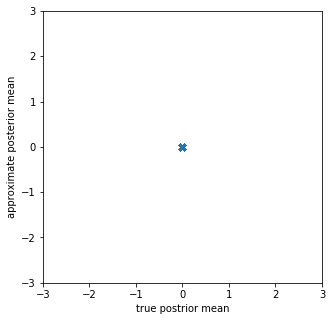

epoch 1 iteration 0 loss 62.164 CE 994.626 KL 0.000 weight 0.002
epoch 1 iteration 100 loss 45.578 CE 729.080 KL 66.967 weight 0.002
epoch 1 iteration 200 loss 42.995 CE 687.669 KL 77.881 weight 0.003
epoch 1 iteration 300 loss 34.178 CE 546.683 KL 41.630 weight 0.004
epoch 1 iteration 400 loss 36.507 CE 583.404 KL 135.045 weight 0.005
epoch 1 iteration 500 loss 31.823 CE 508.622 KL 80.418 weight 0.007
epoch 1 iteration 600 loss 39.857 CE 636.635 KL 124.950 weight 0.009
epoch 1 iteration 700 loss 32.948 CE 526.466 KL 63.243 weight 0.011
epoch 1 iteration 800 loss 32.946 CE 526.048 KL 77.655 weight 0.014
epoch 1 iteration 900 loss 31.437 CE 501.284 KL 94.926 weight 0.018


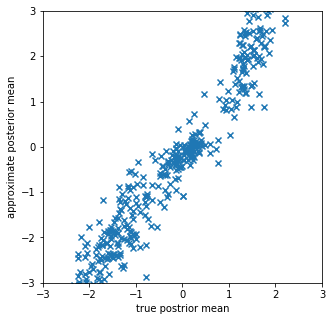

Epoch [1/10], Loss: 31.7553, Perplexity: 61826191764429.45
epoch 2 iteration 1000 loss 38.599 CE 615.545 KL 88.896 weight 0.023
epoch 2 iteration 1100 loss 31.020 CE 494.626 KL 57.690 weight 0.029
epoch 2 iteration 1200 loss 32.350 CE 515.208 KL 64.171 weight 0.037
epoch 2 iteration 1300 loss 28.564 CE 454.046 KL 62.874 weight 0.047
epoch 2 iteration 1400 loss 30.177 CE 479.779 KL 50.867 weight 0.060
epoch 2 iteration 1500 loss 27.672 CE 439.300 KL 45.556 weight 0.076
epoch 2 iteration 1600 loss 36.514 CE 579.598 KL 48.513 weight 0.095
epoch 2 iteration 1700 loss 30.014 CE 475.500 KL 39.596 weight 0.119
epoch 2 iteration 1800 loss 31.036 CE 489.989 KL 44.492 weight 0.148
epoch 2 iteration 1900 loss 30.281 CE 476.450 KL 44.116 weight 0.182


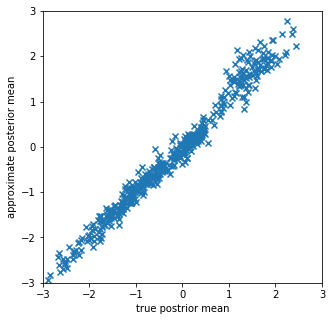

Epoch [2/10], Loss: 30.1311, Perplexity: 12182847184258.90
epoch 3 iteration 2000 loss 36.439 CE 573.121 KL 44.489 weight 0.223
epoch 3 iteration 2100 loss 29.822 CE 466.436 KL 39.831 weight 0.269
epoch 3 iteration 2200 loss 31.180 CE 487.495 KL 35.479 weight 0.321
epoch 3 iteration 2300 loss 28.071 CE 434.593 KL 38.524 weight 0.378
epoch 3 iteration 2400 loss 29.662 CE 460.589 KL 31.984 weight 0.438
epoch 3 iteration 2500 loss 27.923 CE 431.685 KL 30.160 weight 0.500
epoch 3 iteration 2600 loss 35.857 CE 556.690 KL 30.269 weight 0.562
epoch 3 iteration 2700 loss 30.027 CE 461.089 KL 31.081 weight 0.622
epoch 3 iteration 2800 loss 30.664 CE 470.855 KL 29.096 weight 0.679
epoch 3 iteration 2900 loss 31.241 CE 477.387 KL 30.734 weight 0.731


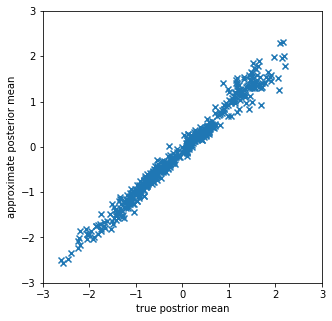

Epoch [3/10], Loss: 30.8434, Perplexity: 24837795070092.35
epoch 4 iteration 3000 loss 36.514 CE 562.959 KL 27.367 weight 0.777
epoch 4 iteration 3100 loss 29.702 CE 452.427 KL 27.895 weight 0.818
epoch 4 iteration 3200 loss 31.445 CE 481.641 KL 25.209 weight 0.852
epoch 4 iteration 3300 loss 28.510 CE 432.333 KL 27.053 weight 0.881
epoch 4 iteration 3400 loss 29.961 CE 456.173 KL 25.647 weight 0.905
epoch 4 iteration 3500 loss 27.805 CE 422.007 KL 24.755 weight 0.924
epoch 4 iteration 3600 loss 36.017 CE 551.051 KL 26.839 weight 0.940
epoch 4 iteration 3700 loss 29.816 CE 453.857 KL 24.358 weight 0.953
epoch 4 iteration 3800 loss 30.705 CE 469.136 KL 23.000 weight 0.963
epoch 4 iteration 3900 loss 30.682 CE 464.360 KL 27.358 weight 0.971


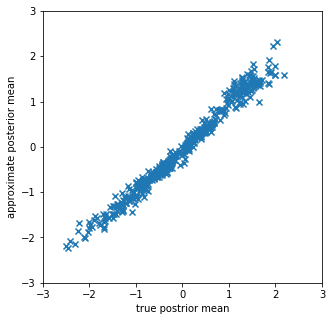

Epoch [4/10], Loss: 30.2049, Perplexity: 13116613405937.22
epoch 5 iteration 4000 loss 36.301 CE 557.907 KL 23.440 weight 0.977
epoch 5 iteration 4100 loss 29.659 CE 452.114 KL 22.840 weight 0.982
epoch 5 iteration 4200 loss 31.078 CE 474.452 KL 23.118 weight 0.986
epoch 5 iteration 4300 loss 28.047 CE 425.066 KL 23.945 weight 0.989
epoch 5 iteration 4400 loss 29.744 CE 452.786 KL 23.323 weight 0.991
epoch 5 iteration 4500 loss 27.945 CE 425.490 KL 21.779 weight 0.993
epoch 5 iteration 4600 loss 36.043 CE 551.663 KL 25.164 weight 0.995
epoch 5 iteration 4700 loss 29.470 CE 449.959 KL 21.647 weight 0.996
epoch 5 iteration 4800 loss 30.365 CE 463.600 KL 22.306 weight 0.997
epoch 5 iteration 4900 loss 31.065 CE 474.217 KL 22.885 weight 0.998


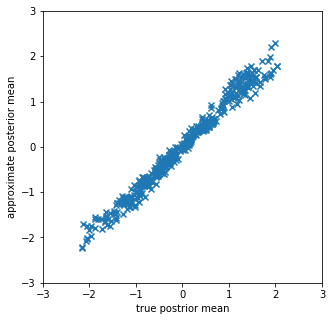

Epoch [5/10], Loss: 29.9765, Perplexity: 10438066540990.54
epoch 6 iteration 5000 loss 35.872 CE 551.845 KL 22.154 weight 0.998
epoch 6 iteration 5100 loss 29.467 CE 448.698 KL 22.813 weight 0.998
epoch 6 iteration 5200 loss 30.608 CE 467.488 KL 22.260 weight 0.999
epoch 6 iteration 5300 loss 27.998 CE 424.696 KL 23.288 weight 0.999
epoch 6 iteration 5400 loss 29.134 CE 443.916 KL 22.239 weight 0.999
epoch 6 iteration 5500 loss 27.957 CE 424.667 KL 22.653 weight 0.999
epoch 6 iteration 5600 loss 35.428 CE 544.986 KL 21.867 weight 1.000
epoch 6 iteration 5700 loss 28.898 CE 441.075 KL 21.299 weight 1.000
epoch 6 iteration 5800 loss 30.337 CE 463.733 KL 21.671 weight 1.000
epoch 6 iteration 5900 loss 30.146 CE 458.421 KL 23.917 weight 1.000


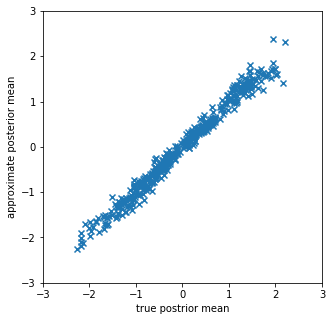

Epoch [6/10], Loss: 29.7940, Perplexity: 8697061689084.06
epoch 7 iteration 6000 loss 35.902 CE 552.910 KL 21.522 weight 1.000
epoch 7 iteration 6100 loss 28.181 CE 428.981 KL 21.912 weight 1.000
epoch 7 iteration 6200 loss 30.377 CE 464.183 KL 21.859 weight 1.000
epoch 7 iteration 6300 loss 27.286 CE 415.262 KL 21.310 weight 1.000
epoch 7 iteration 6400 loss 28.825 CE 437.821 KL 23.386 weight 1.000
epoch 7 iteration 6500 loss 27.978 CE 425.744 KL 21.911 weight 1.000
epoch 7 iteration 6600 loss 35.795 CE 551.034 KL 21.694 weight 1.000
epoch 7 iteration 6700 loss 29.064 CE 445.463 KL 19.570 weight 1.000
epoch 7 iteration 6800 loss 29.868 CE 456.014 KL 21.882 weight 1.000
epoch 7 iteration 6900 loss 29.961 CE 457.465 KL 21.918 weight 1.000


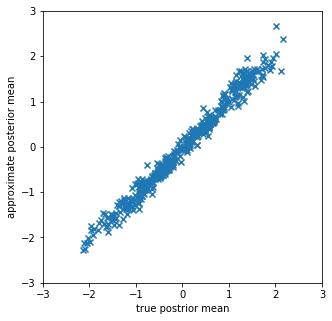

Epoch [7/10], Loss: 29.4264, Perplexity: 6021912006274.39
epoch 8 iteration 7000 loss 35.222 CE 541.424 KL 22.135 weight 1.000
epoch 8 iteration 7100 loss 28.066 CE 426.806 KL 22.251 weight 1.000
epoch 8 iteration 7200 loss 30.278 CE 463.720 KL 20.732 weight 1.000
epoch 8 iteration 7300 loss 27.189 CE 412.934 KL 22.093 weight 1.000
epoch 8 iteration 7400 loss 28.588 CE 434.366 KL 23.040 weight 1.000
epoch 8 iteration 7500 loss 27.512 CE 418.852 KL 21.339 weight 1.000
epoch 8 iteration 7600 loss 35.192 CE 540.386 KL 22.687 weight 1.000
epoch 8 iteration 7700 loss 28.701 CE 437.857 KL 21.361 weight 1.000
epoch 8 iteration 7800 loss 30.224 CE 463.144 KL 20.446 weight 1.000
epoch 8 iteration 7900 loss 29.842 CE 455.100 KL 22.366 weight 1.000


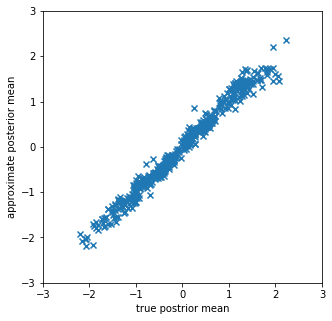

Epoch [8/10], Loss: 29.5541, Perplexity: 6841691878279.47
epoch 9 iteration 8000 loss 35.567 CE 547.134 KL 21.938 weight 1.000
epoch 9 iteration 8100 loss 27.906 CE 424.327 KL 22.173 weight 1.000
epoch 9 iteration 8200 loss 30.239 CE 460.978 KL 22.844 weight 1.000
epoch 9 iteration 8300 loss 26.665 CE 405.144 KL 21.502 weight 1.000
epoch 9 iteration 8400 loss 28.280 CE 430.545 KL 21.937 weight 1.000
epoch 9 iteration 8500 loss 27.577 CE 420.868 KL 20.371 weight 1.000
epoch 9 iteration 8600 loss 35.620 CE 548.123 KL 21.804 weight 1.000
epoch 9 iteration 8700 loss 28.543 CE 436.893 KL 19.795 weight 1.000
epoch 9 iteration 8800 loss 29.385 CE 449.725 KL 20.441 weight 1.000
epoch 9 iteration 8900 loss 29.872 CE 455.876 KL 22.084 weight 1.000


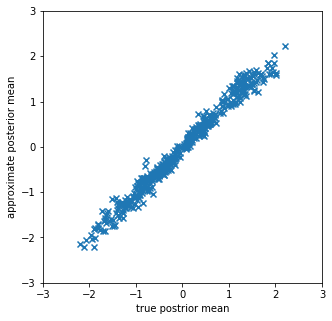

Epoch [9/10], Loss: 28.9269, Perplexity: 3654223282519.88
epoch 10 iteration 9000 loss 34.702 CE 533.838 KL 21.387 weight 1.000
epoch 10 iteration 9100 loss 28.435 CE 435.157 KL 19.811 weight 1.000
epoch 10 iteration 9200 loss 29.908 CE 457.335 KL 21.186 weight 1.000
epoch 10 iteration 9300 loss 27.352 CE 414.429 KL 23.199 weight 1.000
epoch 10 iteration 9400 loss 28.277 CE 429.655 KL 22.781 weight 1.000
epoch 10 iteration 9500 loss 27.592 CE 421.045 KL 20.428 weight 1.000
epoch 10 iteration 9600 loss 34.600 CE 532.626 KL 20.974 weight 1.000
epoch 10 iteration 9700 loss 28.458 CE 434.249 KL 21.082 weight 1.000
epoch 10 iteration 9800 loss 29.305 CE 448.281 KL 20.597 weight 1.000
epoch 10 iteration 9900 loss 29.658 CE 451.963 KL 22.570 weight 1.000


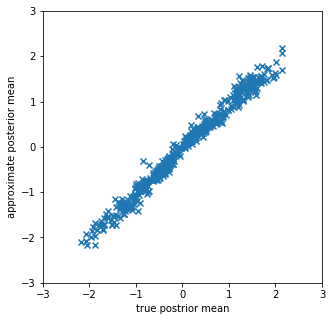

Epoch [10/10], Loss: 29.8287, Perplexity: 9004287782784.83


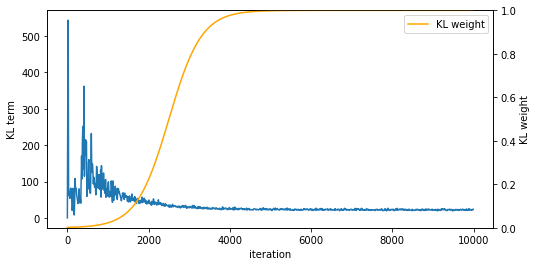

In [153]:
#with annealing
vocab_size = 1000
hidden_size = 50
latent_size = 1
num_layers = 1
step = 0.3
learning_rate = 0.01
epochs = 10

embedding_weights = nn.Embedding(vocab_size, hidden_size).weight
vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

annealing_args = {'type':'logistic', 'step':0, 'k':0.0025, 'first_step':2500}

train(vae, inputs, targets, epochs, vocab_size, hidden_size, latent_size, plot=True, learning_rate=learning_rate,
      synthetic=True, step=step, plot_lim=3, annealing_args=annealing_args, tracked_inputs=tracked_inputs, 
      tracked_targets=tracked_targets)